In [51]:
import numpy as np
import qutip as qt
import pandas as pd
import scipy.optimize as opt

# Reproducing Table 1

In [3]:
ket_0 = qt.basis(2, 0)
ket_1 = qt.basis(2, 1)

ket_00 = qt.tensor(ket_0, ket_0)
ket_11 = qt.tensor(ket_1, ket_1)
ket_01 = qt.tensor(ket_0, ket_1)
ket_10 = qt.tensor(ket_1, ket_0)

a = (np.sqrt(5) - 1) / 2

ket_phi = a * (ket_01 + ket_10) + np.sqrt(1-2*a**2) * ket_11
ket_phi

Quantum object: dims=[[2, 2], [1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.        ]
 [0.61803399]
 [0.61803399]
 [0.48586827]]

In [4]:
rho_phi = ket_phi * ket_phi.dag()
rho_phi

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.         0.         0.         0.        ]
 [0.         0.38196601 0.38196601 0.30028311]
 [0.         0.38196601 0.38196601 0.30028311]
 [0.         0.30028311 0.30028311 0.23606798]]

In [5]:
psi = 1 / np.sqrt(1-a**2) * (np.sqrt(1-2*a**2) * ket_0 - a * ket_1)
proj_psi = psi * psi.dag()

proj_psi

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.38196601 -0.48586827]
 [-0.48586827  0.61803399]]

In [6]:
proj_psi_psi = qt.tensor(proj_psi, proj_psi)
proj_psi_psi

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.14589803 -0.18558517 -0.18558517  0.23606798]
 [-0.18558517  0.23606798  0.23606798 -0.30028311]
 [-0.18558517  0.23606798  0.23606798 -0.30028311]
 [ 0.23606798 -0.30028311 -0.30028311  0.38196601]]

In [7]:
def p_n_k_from_inverted(n):
    proj_excluded = 1-proj_psi_psi

    rho_n = ket_phi * ket_phi.dag()

    return 1 - (proj_excluded * rho_n).tr() ** n

In [8]:
p_n_k_from_inverted(10)

(0.6113105109748465+0j)

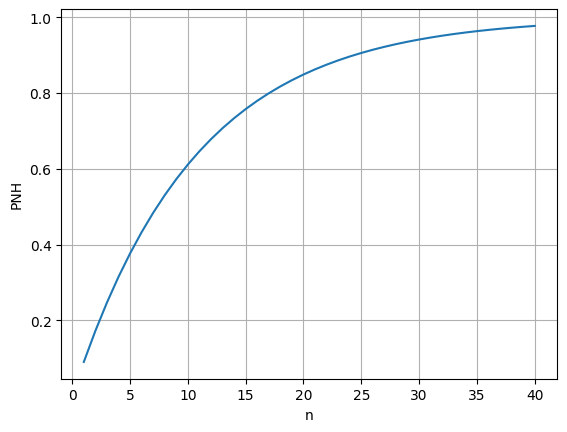

In [9]:
# plot the P(n, k) values for n in [1, 20]
import matplotlib.pyplot as plt

x = list(range(1, 41))
y = [p_n_k_from_inverted(i) for i in x]

# Convert complex values to real to avoid matplotlib warnings
y_real = [val.real if hasattr(val, 'real') else val for val in y]

plt.plot(x, y_real)
plt.xlabel('n')
plt.ylabel('PNH')

plt.grid()

plt.savefig('P_N_H.png')
plt.show()

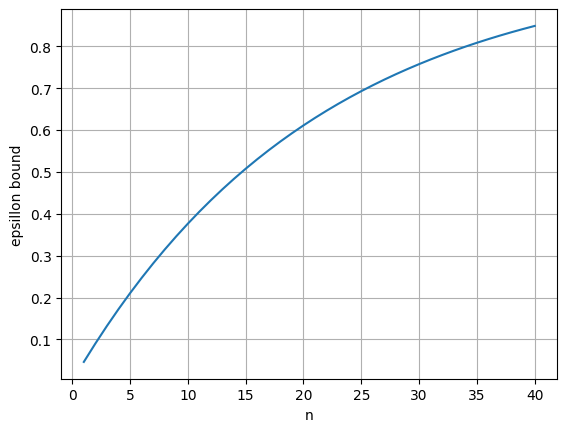

In [10]:
# plot epsillon = 1 - root(1 - P(n, k))
import matplotlib.pyplot as plt
x = list(range(1, 41))
y = [1 - np.sqrt(1 - p_n_k_from_inverted(i)) for i in x]

# Convert complex values to real to avoid matplotlib warnings
y_real = [val.real if hasattr(val, 'real') else val for val in y]

plt.plot(x, y_real)
plt.xlabel('n')
plt.ylabel('epsillon bound')
plt.grid()

plt.savefig('epsillon_bound.png')
plt.show()

# Checking eq. 14

In [11]:
proj_0 = ket_0 * ket_0.dag()
proj_1 = ket_1 * ket_1.dag()

proj_0, proj_1

(Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
 Qobj data =
 [[1. 0.]
  [0. 0.]],
 Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
 Qobj data =
 [[0. 0.]
  [0. 1.]])

## 14a

In [12]:
proj_psi_1 = qt.tensor(proj_psi, proj_1)
proj_psi_1

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.          0.          0.          0.        ]
 [ 0.          0.38196601  0.         -0.48586827]
 [ 0.          0.          0.          0.        ]
 [ 0.         -0.48586827  0.          0.61803399]]

In [13]:
s_01 = 1 - ((1-proj_psi_1) * rho_phi).tr()
s_01

0.0

## 14b

In [14]:
proj_1_psi = qt.tensor(proj_1, proj_psi)
proj_1_psi

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.38196601 -0.48586827]
 [ 0.          0.         -0.48586827  0.61803399]]

In [15]:
s_10 = 1 - ((1-proj_1_psi) * rho_phi).tr()
s_10

0.0

## 14c

In [16]:
proj_0_0 = qt.tensor(proj_0, proj_0)
proj_0_0

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [17]:
# GIVEN 1, 1 !
s_00 = 1 - ((1-proj_0_0) * rho_phi).tr()
s_00

0.0

# Adding Noise

In [18]:
def I(n, rho, kappa):
    p_nh = 1 - ((1-proj_psi_psi) * rho).tr() ** n

    s_01 = 1 - ((1-proj_psi_1) * rho).tr() ** n
    s_10 = 1 - ((1-proj_1_psi) * rho).tr() ** n
    s_00 = 1 - ((1-proj_0_0) * rho).tr() ** n

    return p_nh - kappa * (s_01 + s_10 + s_00)

In [19]:
I(10, rho_phi, 100)

(0.6113105109748465+0j)

In [20]:
noise = 0.1

rho_noisy_phi = (1 - noise) * rho_phi + (noise) / 4
rho_phi, rho_noisy_phi, I(n=5, rho=rho_noisy_phi, kappa=10)

(Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
 Qobj data =
 [[0.         0.         0.         0.        ]
  [0.         0.38196601 0.38196601 0.30028311]
  [0.         0.38196601 0.38196601 0.30028311]
  [0.         0.30028311 0.30028311 0.23606798]],
 Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
 Qobj data =
 [[0.025      0.         0.         0.        ]
  [0.         0.36876941 0.34376941 0.2702548 ]
  [0.         0.34376941 0.36876941 0.2702548 ]
  [0.         0.2702548  0.2702548  0.23746118]],
 (-3.1377085589466898+0j))

## Restricting $\epsilon$ from $I$

In [ ]:
# eq 18
def get_epsilon_tilde_bound(I):
    return 1 - np.sqrt(1 - I)

get_epsilon_tilde_bound(0.07)

np.float64(0.03563492390070455)

In [22]:
# eq 21
def get_epsilon_bound(epsilon_tilde_bound, n, l, kappa):
    return epsilon_tilde_bound - n * np.sqrt(2 / l / kappa)

get_epsilon_bound(0.37, n=10, l=0.1, kappa=30)

np.float64(-7.794965809277261)

In [50]:
# Arrange "realistic" parameters
n_range = range(1, 21)
noise_range = np.logspace(-12, -4, 21) # The noise has to be REALLY small, otherwise there are no positive epsilon bounds
kappa_range = np.logspace(0, 10, 201) 
l_range = [0.2, 1/4]

data_list = []

for n in n_range:
    for noise in noise_range:
        for kappa in kappa_range:
            for l in l_range:
                rho_noisy_phi = (1 - noise) * rho_phi + (noise) / 4
                I_val = I(n, rho_noisy_phi, kappa)
                epsilon_tilde_bound = get_epsilon_tilde_bound(I_val)
                epsilon_bound = get_epsilon_bound(epsilon_tilde_bound, n, l, kappa)
                data_list.append({
                    'n': n,
                    'noise': noise,
                    'kappa': kappa,
                    'l': l,
                    'I': I_val,
                    'epsilon_tilde_bound': epsilon_tilde_bound,
                    'epsilon_bound': epsilon_bound
                })

# Create DataFrame from list of dictionaries
df = pd.DataFrame(data_list)
df = df.sort_values(by=['noise', 'epsilon_bound'], ascending=False)

# Look for positive epsilon bounds with noise on the state
positive_epsilon = df['epsilon_bound'] > 0
non_zero_noise = df['noise'] > 0
df[positive_epsilon & non_zero_noise]

,n,noise,kappa,l,I,epsilon_tilde_bound,epsilon_bound
23481,3,2.511886e-06,12589.254118,0.25,0.175701+0.000000j,0.092091+0.000000j,0.016466+0.000000j
23479,3,2.511886e-06,11220.184543,0.25,0.183439+0.000000j,0.096362+0.000000j,0.016256+0.000000j
31923,4,2.511886e-06,12589.254118,0.25,0.219895+0.000000j,0.116765+0.000000j,0.015931+0.000000j
23483,3,2.511886e-06,14125.375446,0.25,0.167019+0.000000j,0.087322+0.000000j,0.015927+0.000000j
31921,4,2.511886e-06,11220.184543,0.25,0.230212+0.000000j,0.122625+0.000000j,0.015816+0.000000j
...,...,...,...,...,...,...,...
148,1,1.000000e-12,5011.872336,0.20,0.090170+0.000000j,0.046150+0.000000j,0.001482+0.000000j
145,1,1.000000e-12,3981.071706,0.25,0.090170+0.000000j,0.046150+0.000000j,0.001322+0.000000j
8590,2,1.000000e-12,5011.872336,0.20,0.172209+0.000000j,0.090170+0.000000j,0.000833+0.000000j
76132,10,1.000000e-12,7079.457844,0.20,0.611310+0.000000j,0.376550+0.000000j,0.000713+0.000000j


Looks like we can only survive about $10^{-6}$ noise in this noise model which is not experimentally accessible

In [137]:
n_range = range(1, 11)
l = 1/4 

# Optimise over kappa for fixed n and noise to find maximum epsilon bound

noise_range = np.logspace(-12, -1, 128)

data_list = []

for n in n_range:
    for noise in noise_range:
        result = opt.minimize_scalar(lambda kappa: -get_epsilon_bound(
            get_epsilon_tilde_bound(I(n, (1 - noise) * rho_phi + (noise) / 4, kappa)),
            n, l, kappa
        ), bounds=(1, 1e10), method='bounded')
        if result.success:
            kappa_opt = result.x
            epsilon_bound_opt = -result.fun
            data_list.append({
                'n': n,
                'noise': noise,
                'kappa_opt': kappa_opt,
                'l': l,
                'rho_phi': rho_phi,
                'epsilon_bound_opt': epsilon_bound_opt
            })
        else:
            print(f"Optimization failed for noise: {noise:.2e}")
# Create DataFrame from list of dictionaries
df = pd.DataFrame(data_list)

df

,n,noise,kappa_opt,l,rho_phi,epsilon_bound_opt
0,1,1.000000e-12,2.348639e+08+0.000000e+ 00j,0.25,"Quantum object: dims=[[2, 2], [2, 2]], shape=(...",0.045873+0.000000j
1,1,1.220715e-12,2.055958e+08+0.000000e+ 00j,0.25,"Quantum object: dims=[[2, 2], [2, 2]], shape=(...",0.045854+0.000000j
2,1,1.490144e-12,1.799835e+08+0.000000e+ 00j,0.25,"Quantum object: dims=[[2, 2], [2, 2]], shape=(...",0.045834+0.000000j
3,1,1.819041e-12,1.575639e+08+0.000000e+ 00j,0.25,"Quantum object: dims=[[2, 2], [2, 2]], shape=(...",0.045812+0.000000j
4,1,2.220530e-12,1.379491e+08+0.000000e+ 00j,0.25,"Quantum object: dims=[[2, 2], [2, 2]], shape=(...",0.045789+0.000000j
...,...,...,...,...,...,...
1275,10,4.503429e-02,5.046031e+01+0.000000e+ 00j,0.25,"Quantum object: dims=[[2, 2], [2, 2]], shape=(...",-7.051638+0.000000j
1276,10,5.497402e-02,4.587240e+01+0.000000e+ 00j,0.25,"Quantum object: dims=[[2, 2], [2, 2]], shape=(...",-7.434994+0.000000j
1277,10,6.710759e-02,4.175573e+01+0.000000e+ 00j,0.25,"Quantum object: dims=[[2, 2], [2, 2]], shape=(...",-7.831708+0.000000j
1278,10,8.191922e-02,3.806726e+01+0.000000e+ 00j,0.25,"Quantum object: dims=[[2, 2], [2, 2]], shape=(...",-8.240728+0.000000j


/Users/Joseph/Documents/PhD/projects/bell-non-locality/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/Joseph/Documents/PhD/projects/bell-non-locality/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


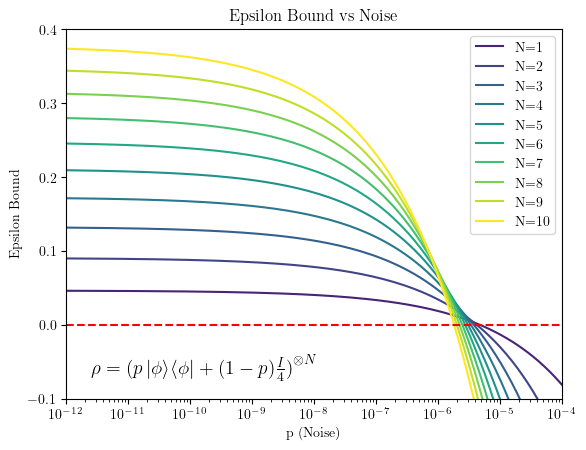

In [166]:
# plot the results with colour for n values
x = df['noise']
y = df['epsilon_bound_opt']
colors = df['n'].astype(int) / df['n'].max()

# add line between points with same n value
for n in df['n'].unique():
    df_n = df[df['n'] == n]
    plt.plot(df_n['noise'], df_n['epsilon_bound_opt'], label=f'N={n}', color=plt.cm.viridis(n / df['n'].max()))
plt.legend()
plt.xscale('log')

# Add a line at y=0
plt.axhline(0, color='red', linestyle='--')

plt.xlim(1e-12, 1e-4)
plt.ylim(-0.1, 0.4)

plt.xlabel('p (Noise)')
plt.ylabel('Epsilon Bound')
plt.title('Epsilon Bound vs Noise')

plt.rcParams['text.usetex'] = True
# use a nice font
plt.rcParams['font.family'] = 'computer modern'

# add text box with the noise model
textstr = r'$\rho = \bigl(p \, |\phi\rangle\langle \phi| + (1-p) \frac{I}{4}\bigr)^{\otimes N}$'
# place a text box in bottom left in axes coords

plt.text(0.05, 0.05, textstr, transform=plt.gca().transAxes, fontsize=14, verticalalignment='bottom')

plt.savefig('epsilon_bound_vs_noise.png')

plt.show()

In [118]:
df['abs_epsilon_bound_opt'] = df['epsilon_bound_opt'].abs()

positive_epsilon = df[(df['n'] == 1) & (df['epsilon_bound_opt'] > 0)].sort_values(by='abs_epsilon_bound_opt').iloc[0]
rho_phi_positive_bound = positive_epsilon['rho_phi']
rho_phi_positive_bound, rho_phi_positive_bound.purity(), positive_epsilon['epsilon_bound_opt'], positive_epsilon['noise'], positive_epsilon['kappa_opt']

(Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
 Qobj data =
 [[0.         0.         0.         0.        ]
  [0.         0.38196601 0.38196601 0.30028311]
  [0.         0.38196601 0.38196601 0.30028311]
  [0.         0.30028311 0.30028311 0.23606798]],
 1.0,
 np.complex128(0.0029536071092203173+0j),
 np.float64(3.8254027466328745e-06),
 np.complex128(9695.060647943263+0j))

In [ ]:
# get the psi density matrix for that p
p = df[(df['n'] == 1) & (df['abs_epsilon_bound_opt'] > 0)].sort_values(by='abs_epsilon_bound_opt').head(1)['noise']
psi = 1 / np.sqrt(1-a**2) * (np.sqrt(1-2*a**2) * ket_0 - a * ket_1)
proj_psi = psi * psi.dag()

1.0